Compares EIA historical forecast, for ERCO network (texas) versus the actual demand. Those forecasts are set 24 hours in advance and the model does not re-fit every hour. Compared is our model in the second half, which re-fits each hour, starting sequentially nn

In [1]:
from statsmodels.tsa.api import SimpleExpSmoothing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from my_functions import *
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

In [2]:
parser = lambda x: datetime.strptime(x, '%Y%m%dT%HZ')
nrg = pd.read_csv('../data/all_erco_energy.csv', parse_dates=['datetime'], date_parser=parser)

In [3]:
# Check to see last day where data is complete (first day where null)
nrg_na = nrg[nrg['demand'].isnull()]
nrg_na.index[0]

28379

In [4]:
date_floor = '2018-11-12'
date_ceil = '2022-02-06 05'
nrg = nrg[(nrg['datetime'] > date_floor) & (nrg['datetime'] < date_ceil)].set_index('datetime')
print(nrg.shape)

(28366, 12)


In [5]:
print(nrg.index[0])
print(nrg.index[-1])

2022-02-06 04:00:00
2018-11-12 07:00:00


---

## Actual Demand Versus US EIA Forecasted Demand (Baseline Model)

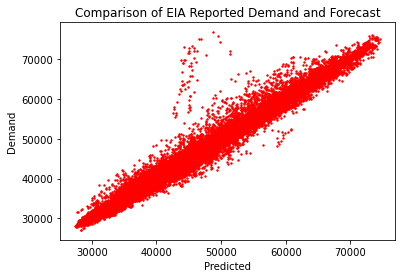

In [6]:
base_error = pd.DataFrame({'Demand': nrg['demand'],
                           'Predicted': nrg['forecast']})

plt.scatter(base_error['Demand'], base_error['Predicted'], s=2,c='red')
plt.xlabel('Predicted')
plt.ylabel('Demand')
plt.title('Comparison of EIA Reported Demand and Forecast')
plt.savefig('../output/comparing_base_demand_forecast_scatter.png')

### last Month and a Half

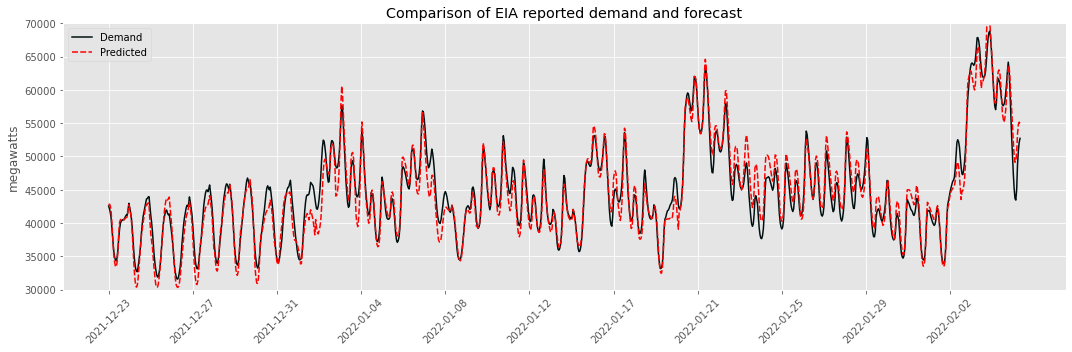

In [7]:
df = base_error
df = df[df.index > '2021-12-23']
df.sort_index(ascending=True, inplace=True)
plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
sns.lineplot(data=df[['Demand','Predicted']], palette=['#001011', 'red'])
plt.ylabel('megawatts')
plt.xlabel('')
plt.ylim(bottom=30000, top=70000)
plt.xticks(ticks=df.index[::100], rotation=45)
plt.title('Comparison of EIA reported demand and forecast')
plt.tight_layout()
plt.savefig('../output/comparing_base_demand_forecast_line.png')
plt.show();

## Baseline Model Metrics

In [8]:
df = base_error
df['Error'] = df['Demand'] - df['Predicted']

In [9]:
#BASE MODEL METRICS
mae_function(df)

Bias: -173.09, -0.39%
MAE: 1107.15, 2.53%
RMSE: 1830.83, 4.18%


### Residuals

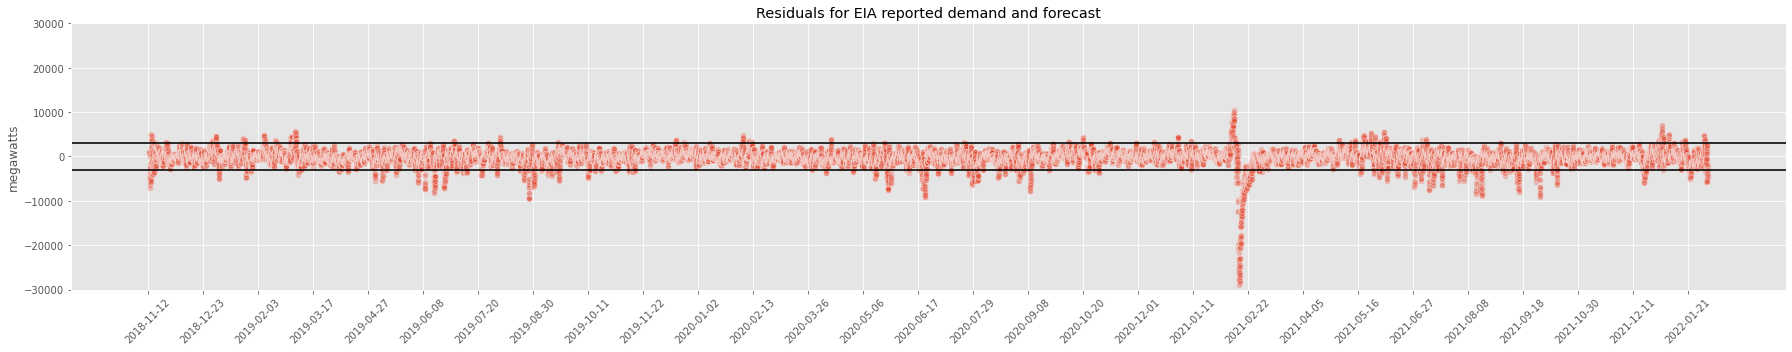

In [10]:
df.sort_index(ascending=True, inplace=True)
plt.figure(figsize=(25,5))
sns.lineplot(x=df.index,y=df['Error'], linestyle='',marker='o', alpha=0.3)
plt.ylabel('megawatts')
plt.xlabel('')
plt.ylim(bottom=-30000, top=30000)
plt.xticks(ticks=df.index[::1000], rotation=45)
plt.title('Residuals for EIA reported demand and forecast')
plt.style.use('ggplot')
plt.axhline(y = 3000, color='black', linewidth=2, alpha=.8)
plt.axhline(y = -3000, color='black', linewidth=2, alpha=.8)
plt.tight_layout()
plt.savefig('../output/basemodel_residuals.png')
plt.show();

biased towards forecast being greater than actual demand, that's preferable since excess energy can always be sent off but not generating enough can pose a major threat to the grid.

---

### Our Model

In [11]:
from datetime import datetime
parser = lambda x: datetime.strptime(x, '%Y%m%dT%HZ')

nrg = pd.read_csv('../data/all_erco_energy.csv', parse_dates=['datetime'], date_parser=parser)

In [12]:
nrg = nrg.dropna()

In [13]:
d = nrg['demand']

In [14]:
test = exp_smooth_funct(d, slen=12000, extra_periods=1, alpha=0.4, beta=0.4, phi=0.8, gamma=0.2)

In [15]:
mae_function(test)

Bias: -0.93, -0.00%
MAE: 1337.39, 3.03%
RMSE: 1687.98, 3.83%


### Rejoin date-time to model output

In [16]:
#print(nrg.head())
#print(test.head(5))
#print(nrg.tail())
#print(test.tail(5))
nrg.reset_index(inplace=True)
nrg.head(5)

,index,datetime,demand,plant,net_generation,coal,hydro,natural_gas,nuclear,other,solar,wind,total_interchange,forecast
0,11,2022-02-06 06:00:00,51910.0,ERCO,51687.0,8792.0,10.0,17825.0,5144.0,121.0,0.0,19795.0,-222.0,51511.0
1,12,2022-02-06 05:00:00,52424.0,ERCO,52179.0,9077.0,10.0,17796.0,5144.0,122.0,0.0,20030.0,-245.0,53249.0
2,13,2022-02-06 04:00:00,52723.0,ERCO,52350.0,9022.0,11.0,18119.0,5143.0,128.0,0.0,19925.0,-372.0,54965.0
3,14,2022-02-06 03:00:00,52136.0,ERCO,51572.0,8382.0,30.0,17950.0,5144.0,146.0,0.0,19921.0,-563.0,55162.0
4,15,2022-02-06 02:00:00,50843.0,ERCO,50199.0,8531.0,30.0,18028.0,5144.0,145.0,0.0,18323.0,-643.0,54814.0


In [17]:
test = test[0:31460]


In [18]:
test_error = pd.DataFrame({'Demand': test['Demand'],
                           'Predicted': test['Forecast'],
                           'Resid': test['Error'],
                           'datetime': nrg['datetime']})

In [19]:
#print(test_error.head(5))
#print(test_error.tail(5))

### Model Performance (predicted versus demand)

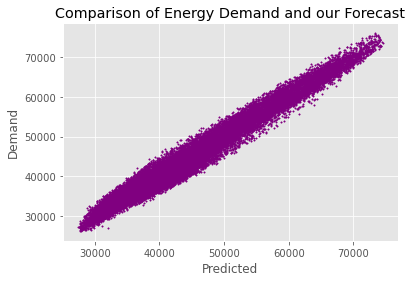

In [20]:
plt.scatter(test_error['Demand'], test_error['Predicted'], s=2, c='purple')
plt.xlabel('Predicted')
plt.ylabel('Demand')
plt.title('Comparison of Energy Demand and our Forecast')
plt.savefig('../output/comparing_test_demand_forecast_scatter.png')

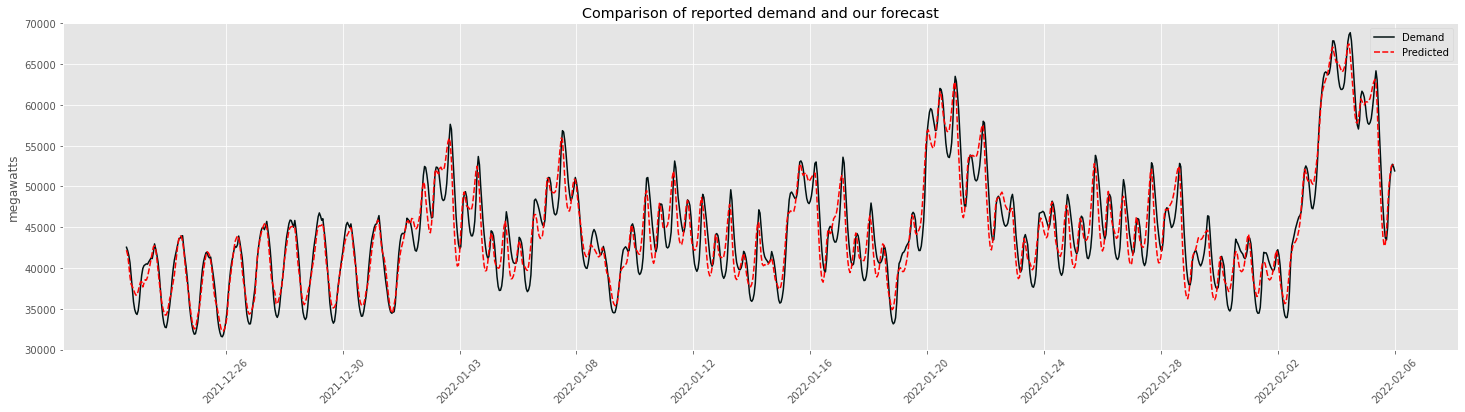

In [21]:
df = test_error[test_error['datetime'] > '2021-12-23'].set_index('datetime')
plt.figure(figsize=(25, 6))
plt.style.use('ggplot')
sns.lineplot(data=df[['Demand','Predicted']], palette=['#001011', 'red'])
plt.ylabel('megawatts')
plt.xlabel('')
plt.ylim(bottom=30000, top=70000)
plt.xticks(ticks=df.index[::100], rotation=45)
plt.title('Comparison of reported demand and our forecast')
plt.savefig('../output/comparing_ourmodel_demand_forecast1.png')
plt.show();

### Residuals

In [22]:
df= test_error

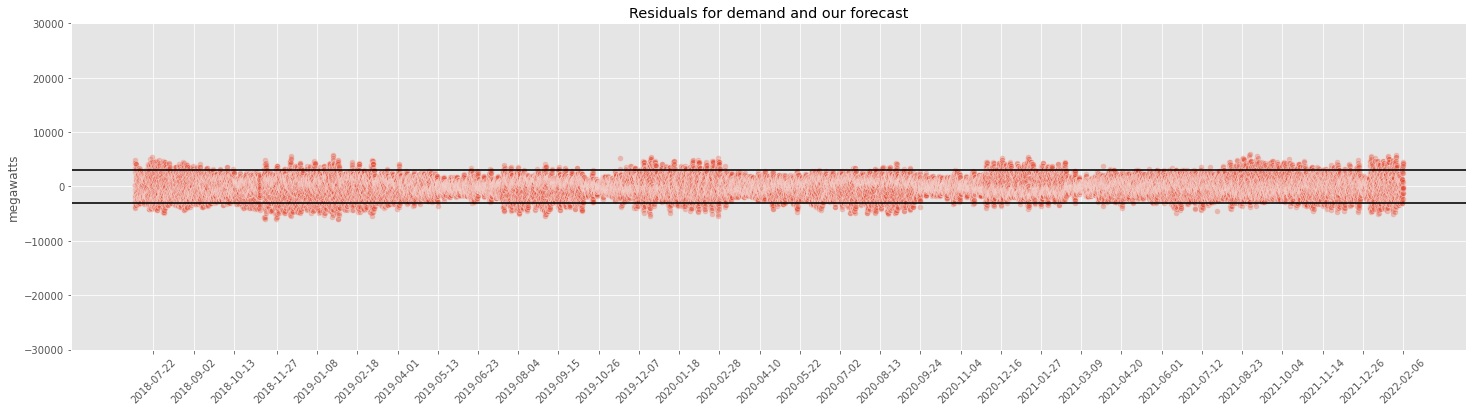

In [23]:

df= test_error.set_index('datetime')
plt.figure(figsize=(25, 6))
plt.style.use('ggplot')
sns.lineplot(x=df.index,y=df['Resid'], linestyle='',marker='o', alpha=0.3)
plt.ylabel('megawatts')
plt.xlabel('')
plt.ylim(bottom=-30000, top=30000)
plt.xticks(ticks=df.index[::1000], rotation=45)
plt.title('Residuals for demand and our forecast')
plt.axhline(y = 3000, color='black', linewidth=2, alpha=.8)
plt.axhline(y = -3000, color='black', linewidth=2, alpha=.8)
plt.savefig('../output/ourmodel_residuals.png')
plt.show();